# 1. **Develop solution:**  Scene Change Detection

## 1.1. Introduction

## 1.2.  Install the modeling requirements and libraries

First, we'll need to **install some libraries** that are not part of our container image. Normally, **Red Hat OpenShift Data Science** or **Red Hat Open Data Hub** is already taking care of this for you, based on what it detects in the code. **Red Hat OpenShift Data Science** or **Red Hat Open Data Hub** will reinstall all those libraries for you every time you launch the notebook!

In case you're using this notebook in a different environment, or just to make sure everything is ready, you can run the following cell to install  Keras (an abstraction layer over Tensorflow).

## 1.3.  Importing the needed libraries and packages
Of course, we'll need to import various packages. They are either built in the notebook image you are running, or have been installed in the previous step.

In [4]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [5]:
os.chdir('/opt/app-root/src/predictive-maint/')
os.environ["REPO_PATH"]="/opt/app-root/src/predictive-maint/"

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from training.src.dataloading.read_dataset import readData
from training.src.features.data_preprocessing import preprocessData
from training.src.visualization.visualize import visualizeData
from training.src.modules.build_model import buildModel
from training.src.modules.train_model import  trainModel,MLflow
from training.src.modules.predict_model import predictor
from training.src.hyper_parameters.hps import get_hyper_paras
# from training.src.github_commands.git_utils import gitCommands
from training.src.deploy_app.deploy import deployApplication



import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
import warnings
import numpy as np
from minio import Minio
import zipfile

## 1.4. Initialize some hyper-parameters

In [7]:
SPLITE_RATE, OUTPUT_FEATURE_NAME, BATCH_SIZE, IMAGE_SIZE, INPUT_SHAPE, DROP_OUT_RATE, EPOCHS, SEED, TRAIN_DATA_FLAG, FINE_TUNE_FLAG = get_hyper_paras()
SPLITE_RATE, OUTPUT_FEATURE_NAME, BATCH_SIZE, IMAGE_SIZE, INPUT_SHAPE, DROP_OUT_RATE, EPOCHS, SEED, TRAIN_DATA_FLAG, FINE_TUNE_FLAG

/opt/app-root/src----predictive-maint


(0.2,
 ['Background', 'Person', 'Finger'],
 32,
 (256, 256),
 (256, 256, 3),
 0.2,
 3,
 100,
 True,
 False)

### 1.4.1. Define a client to read from Minio S3 Bucket

In [8]:
def get_s3_server():
    minioClient = Minio(os.environ['MLFLOW_S3_ENDPOINT'],
                    access_key=os.environ['AWS_ACCESS_KEY_ID'],
                    secret_key=os.environ['AWS_SECRET_ACCESS_KEY'],
                    secure=False)

    return minioClient
client = get_s3_server()

### 1.4.2. SetUp MLFlow to track the model

In [9]:
mlflow = MLflow(mlflow).SetUp_Mlflow()

## 1.5. Reading the  Dataset


In [10]:
train_ds, val_ds, test_ds, num_classes = readData(dataPath = os.environ['DATA_PATH'],imageSize = IMAGE_SIZE, batchSize = BATCH_SIZE, seed = SEED  ).generateData()

Found 32 files belonging to 3 classes.
Using 26 files for training.
Found 32 files belonging to 3 classes.
Using 6 files for validation.
Found 32 files belonging to 3 classes.
Using 6 files for validation.


## 1.6.  Data Preprocessing

We need to resize the data to make them ready for feeing to our model

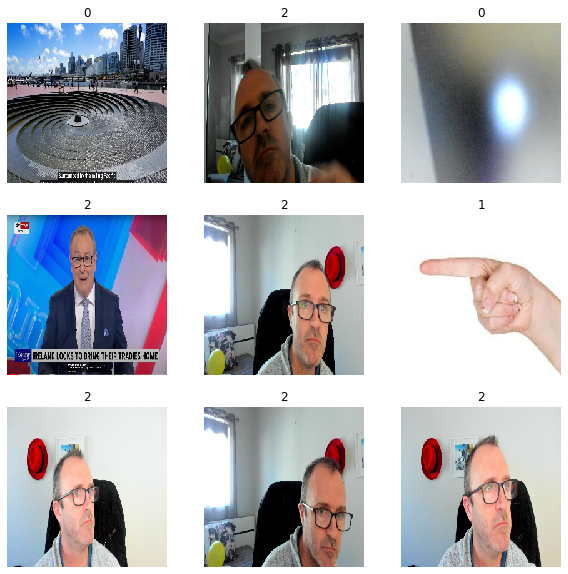

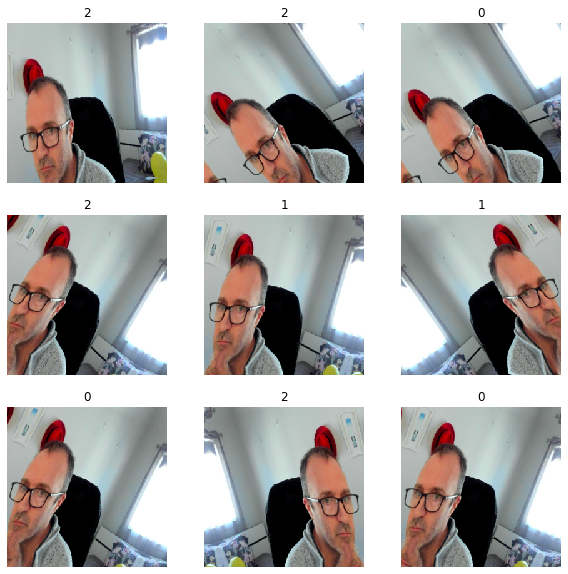

In [11]:
train_ds, val_ds, test_ds, data_augmentation  = preprocessData(trainDs = train_ds,testDs = test_ds,valDs = val_ds,numClasses = num_classes,augFlag=True,height=IMAGE_SIZE[0],width=IMAGE_SIZE[1],batchSize = BATCH_SIZE).dataPreProcessing()

In [12]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [13]:
val_ds


<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## 1.7.  Design and compile the model 

In [14]:
clf = buildModel(dataAugmentation = data_augmentation, inputShape=INPUT_SHAPE, numClasses=num_classes, topDropoutRate=DROP_OUT_RATE).setupModel()
# clf.summary()

## 1.8.  Training the Model

In [ ]:
clf = trainModel(model = clf, trainDs = train_ds, valDs = val_ds, batchSize=32, epochs=3, mlflow=mlflow).ModelTraining()


In [16]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# 3. **Deploy solution as an app with model serving tool Seldon** 

In [ ]:
os.environ['OPENSHIFT_CLIENT_PYTHON_DEFAULT_OC_PATH'] = '/opt/app-root/bin/oc'

deployApplication().deployApp()

# 4. **Test the Predictive Maintenance app** 

## 4.1. Get the app route

In [ ]:
# This cell reads the name of the route from a file that was created in the previous cell's call. 
with open('routeHost.txt') as f:
    lines = f.readlines()
    
routeHost=lines[0]

path='/api/v1.0/predictions'

my_route = 'http://'+routeHost+path
# print ("my_route----"+my_route)



## 4.2. Read the test data 

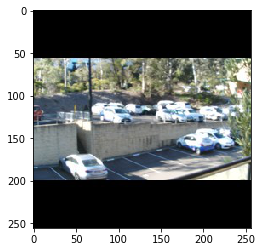

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open("/opt/app-root/src/predictive-maint/training/notebooks/sample.jpg")
img = np.asarray(im)
plt.imshow(img)
plt.show()

## 4.3. Make a decision based on input data

In [20]:

import base64
import requests
from json import dumps
my_image = '/opt/app-root/src/predictive-maint/training/notebooks/sample.jpg'
with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

content = {"data":
          {
                "names":
                    ["Sentence"],
             "ndarray": img.tolist()

          }
        }
json_data = dumps(content)
headers = {"Content-Type" : "application/json"}





r = requests.post(my_route , data=json_data, headers=headers)
r.json()

'{"Predicted Class: ": "Background", "Predicted Label: ": "[0]", "Predicted Class Prob: ": "\\"[0.6663093]\\"", "All Probs: ": "[[0.6663092970848083, 0.1875816285610199, 0.14610913395881653]]"}'

In [21]:
import os
import tensorflow as tf

import joblib
import numpy as np
import json
import traceback
import sys


class Predictor(object):
    
    def __init__(self):
        self.loaded = False
        self.labels = ["Background","Finger","Person"]

    def load(self):

        print("Loading model",os.getpid())
        self.model = tf.keras.models.load_model( '/opt/app-root/src/predictive-maint/training/deploy/model.h5', compile=False)
        print("Model Loaded!")
        self.loaded = True
        print("Loaded model")

    def predict_raw(self, data):
        print('step 00')
        if data:
            float_array = tf.constant(np.array(data))
            float_array = tf.expand_dims(float_array, 0)
            print('step 01')

        print ('step1......')
        print(float_array.shape)

      
        if not self.loaded:
            self.load()
        try:
            result = self.model.predict(float_array) 
        except Exception as e:
            print(traceback.format_exception(*sys.exc_info()))
        
        ######


        
        json_results = {}
        arg_max_result = tf.math.argmax(result,axis=1)
        print("1"*50)
        print(arg_max_result)
        json_results["Predicted Class: "] = str(self.labels[int(arg_max_result)])
        print("2"*50)
        
        json_results["Predicted Label: "] = json.dumps(arg_max_result.numpy(), cls=JsonSerializer)
        print("3"*50)
        json_results["Predicted Class Prob: "] = json.dumps(str(np.max(result, axis=1)), cls=JsonSerializer)
        print("4"*50)
        json_results["All Probs: "] = json.dumps(result, cls=JsonSerializer)
        
        
        print(json_results)
        print (result)
        print(json.dumps(json_results))
        return json.dumps(json_results)
        # return json.dumps(result.numpy(), cls=JsonSerializer)

class JsonSerializer(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
Predictor().predict_raw(img.tolist())

__Thank you for your time!__